# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [ ]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [ ]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

100%|██████████| 26421880/26421880 [00:04<00:00, 5311680.67it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 146230.43it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1588627.59it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5377902.12it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [ ]:
# Set up data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [ ]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = criterion(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [ ]:
embedding_net = EmbeddingNet().to(device)

n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [ ]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

    # Train stage
    train_loss, acc = train_epoch(train_loader, model, criterion, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, criterion)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Iteration 0: Loss = 2.358445882797241
Iteration 20: Loss = 1.8023756742477417
Iteration 40: Loss = 1.6385241746902466
Iteration 60: Loss = 1.525803565979004
Iteration 80: Loss = 1.4267405271530151
Iteration 100: Loss = 1.2471801042556763
Iteration 120: Loss = 1.1570460796356201
Iteration 140: Loss = 0.9571957588195801
Iteration 160: Loss = 1.1255980730056763
Iteration 180: Loss = 0.9579949975013733
Iteration 200: Loss = 1.0630236864089966
Iteration 220: Loss = 1.125508189201355
Epoch: 1/10. Train set: Average loss: 1.3048 Accuracy: 57.44
Epoch: 1/10. Validation set: Average loss: 0.9168 Accuracy: 76.77
Iteration 0: Loss = 1.0384865999221802
Iteration 20: Loss = 0.7523639798164368
Iteration 40: Loss = 0.949934184551239
Iteration 60: Loss = 0.7766504287719727
Iteration 80: Loss = 0.9942624568939209
Iteration 100: Loss = 1.0380446910858154
Iteration 120: Loss = 0.8055434226989746
Iteration 140: Loss = 0.7253530621528625
Iteration 160: Loss = 0.7491171956062317
Iteration 180: Loss = 0.6866

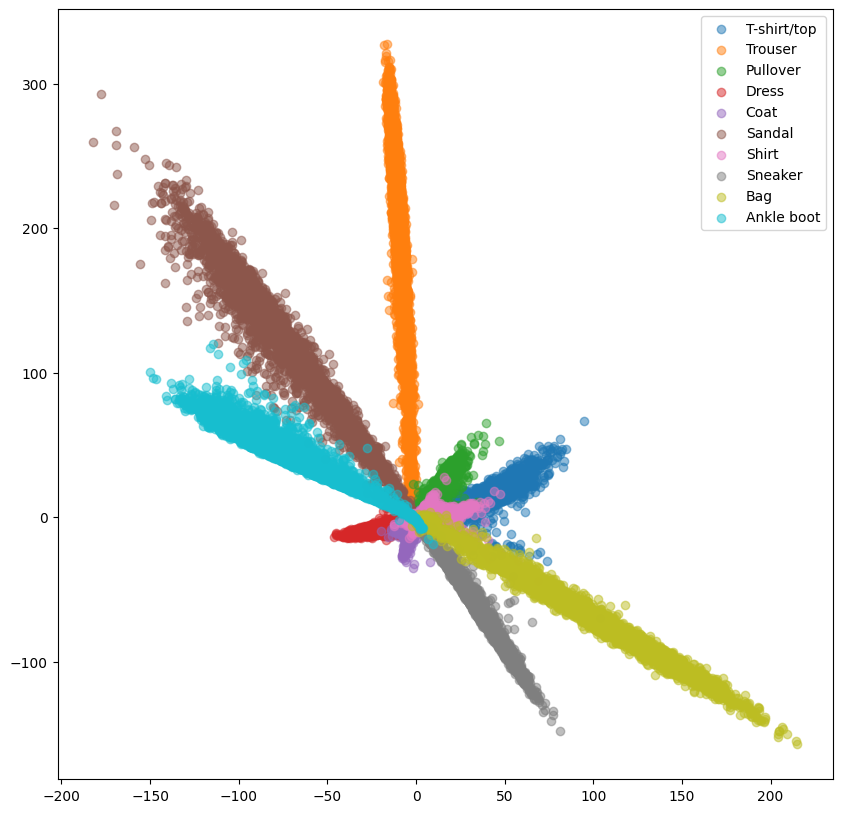

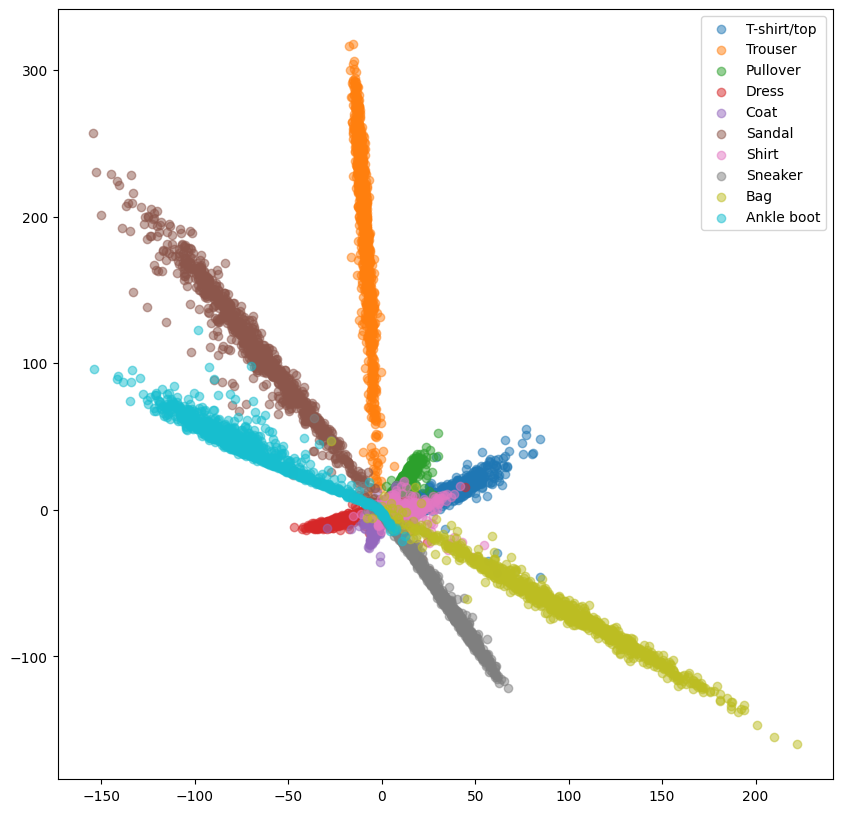

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train # boolean indicate if it is the training set
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through transform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target


    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

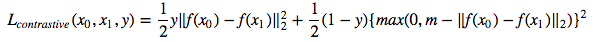

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Max-margin Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [ ]:
def train_epoch_siamese(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = criterion(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = criterion(output1, output2, target)
        val_loss += loss.item()

    return val_loss

In [ ]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)   # Note that the train datasets has self.train == True, and the test has self.train == False

batch_size = 256
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

margin = 1.

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)

criterion = ContrastiveLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [ ]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, criterion, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, criterion)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Iteration 0: Loss = 0.2510164976119995
Iteration 20: Loss = 0.06662244349718094
Iteration 40: Loss = 0.06615293025970459
Iteration 60: Loss = 0.05505891516804695
Iteration 80: Loss = 0.05411573126912117
Iteration 100: Loss = 0.04744641110301018
Iteration 120: Loss = 0.04810639098286629
Iteration 140: Loss = 0.048159319907426834
Iteration 160: Loss = 0.04171814024448395
Iteration 180: Loss = 0.040465664118528366
Iteration 200: Loss = 0.04387684166431427
Iteration 220: Loss = 0.043753888458013535
Epoch: 1/10. Train set: Average loss: 0.0536
Epoch: 1/10. Validation set: Average loss: 0.0430
Iteration 0: Loss = 0.02665409818291664
Iteration 20: Loss = 0.045888371765613556
Iteration 40: Loss = 0.03429820016026497
Iteration 60: Loss = 0.041758909821510315
Iteration 80: Loss = 0.033303096890449524
Iteration 100: Loss = 0.036104194819927216
Iteration 120: Loss = 0.04150259494781494
Iteration 140: Loss = 0.03468960151076317
Iteration 160: Loss = 0.04008651524782181
Iteration 180: Loss = 0.04477

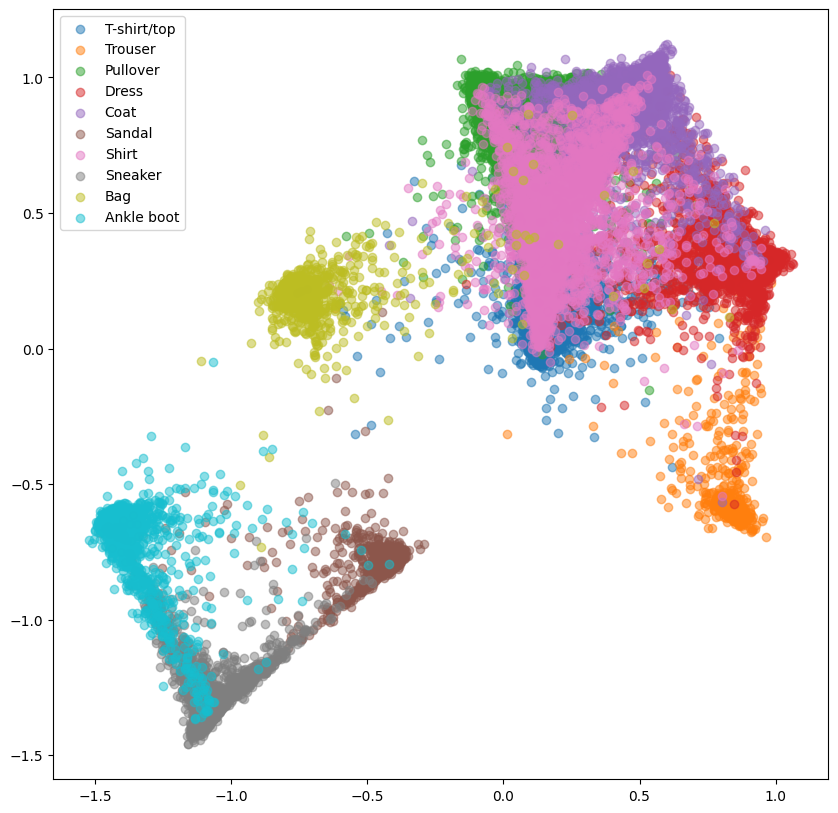

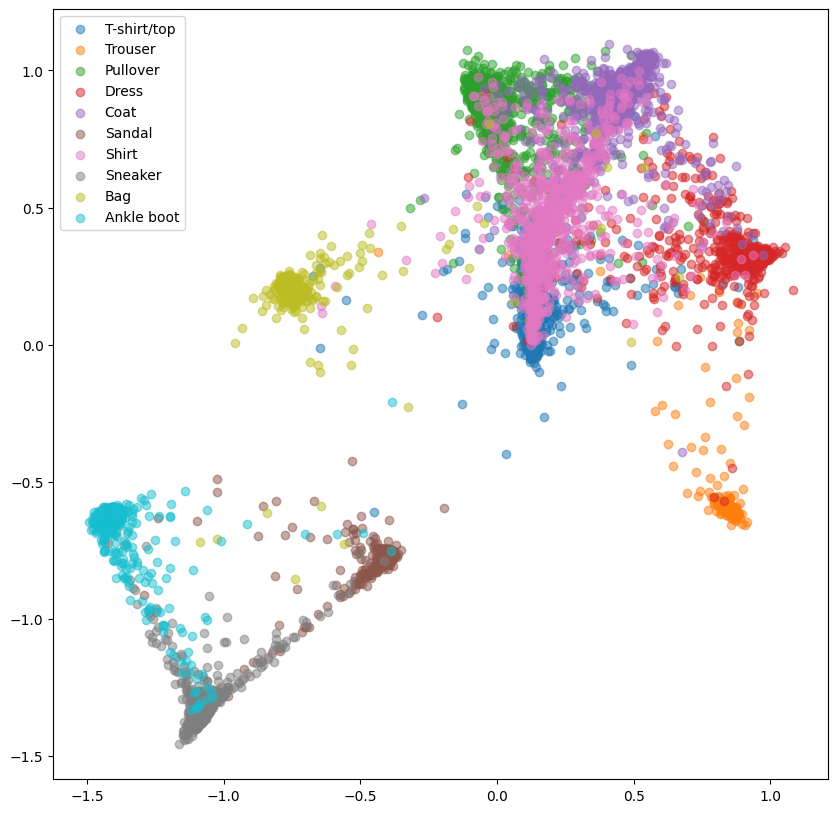

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In this case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings.

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

Install the required packages below. Uncomment the corresponding cell to use the package manager that suits your installation (for Google Colab, that would be pip).

In [ ]:
#%conda install -y -c metric-learning pytorch-metric-learning=2.1.1
#%conda install -y -c conda-forge faiss-gpu=1.6.5

In [ ]:
%pip install pytorch-metric-learning faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

In [ ]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [ ]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(data)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(query = train_embeddings, reference = test_embeddings, query_labels = train_labels, reference_labels = test_labels)

    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 0.9981822371482849, Number of mined triplets = 1489444
Epoch 1 Iteration 20: Loss = 0.9983485341072083, Number of mined triplets = 710105
Epoch 1 Iteration 40: Loss = 0.9900882244110107, Number of mined triplets = 455687
Epoch 1 Iteration 60: Loss = 1.0481659173965454, Number of mined triplets = 390489
Epoch 1 Iteration 80: Loss = 1.0011157989501953, Number of mined triplets = 341746
Epoch 1 Iteration 100: Loss = 1.000959873199463, Number of mined triplets = 561774
Epoch 1 Iteration 120: Loss = 1.0067939758300781, Number of mined triplets = 429499
Epoch 1 Iteration 140: Loss = 1.0385196208953857, Number of mined triplets = 297437
Epoch 1 Iteration 160: Loss = 1.0013960599899292, Number of mined triplets = 312709
Epoch 1 Iteration 180: Loss = 0.9837428331375122, Number of mined triplets = 287496
Epoch 1 Iteration 200: Loss = 0.996548593044281, Number of mined triplets = 323596
Epoch 1 Iteration 220: Loss = 1.002751111984253, Number of mined triplets = 274759


  0%|          | 0/1875 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 313/313 [00:03<00:00, 86.66it/s]


Computing accuracy


/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Test set accuracy (Precision@1) = 0.6626500000000001
Epoch 2 Iteration 0: Loss = 0.9674334526062012, Number of mined triplets = 278808
Epoch 2 Iteration 20: Loss = 1.0270882844924927, Number of mined triplets = 263124
Epoch 2 Iteration 40: Loss = 0.970672607421875, Number of mined triplets = 234843
Epoch 2 Iteration 60: Loss = 1.013234257698059, Number of mined triplets = 318292
Epoch 2 Iteration 80: Loss = 0.9963164925575256, Number of mined triplets = 248544
Epoch 2 Iteration 100: Loss = 1.085739254951477, Number of mined triplets = 262046
Epoch 2 Iteration 120: Loss = 0.9766098260879517, Number of mined triplets = 302766
Epoch 2 Iteration 140: Loss = 0.9654823541641235, Number of mined triplets = 339907
Epoch 2 Iteration 160: Loss = 1.0213077068328857, Number of mined triplets = 290047
Epoch 2 Iteration 180: Loss = 1.0082969665527344, Number of mined triplets = 252315
Epoch 2 Iteration 200: Loss = 1.0524115562438965, Number of mined triplets = 217048
Epoch 2 Iteration 220: Loss = 1.

100%|██████████| 313/313 [00:02<00:00, 114.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7015333333333333
Epoch 3 Iteration 0: Loss = 1.0149214267730713, Number of mined triplets = 237407
Epoch 3 Iteration 20: Loss = 0.9751929044723511, Number of mined triplets = 256341
Epoch 3 Iteration 40: Loss = 0.9807815551757812, Number of mined triplets = 265624
Epoch 3 Iteration 60: Loss = 0.9858689308166504, Number of mined triplets = 220876
Epoch 3 Iteration 80: Loss = 0.9669706225395203, Number of mined triplets = 275867
Epoch 3 Iteration 100: Loss = 0.9738456010818481, Number of mined triplets = 347700
Epoch 3 Iteration 120: Loss = 1.0177083015441895, Number of mined triplets = 241563
Epoch 3 Iteration 140: Loss = 0.9686203598976135, Number of mined triplets = 194834
Epoch 3 Iteration 160: Loss = 0.985975980758667, Number of mined triplets = 227582
Epoch 3 Iteration 180: Loss = 0.9617647528648376, Number of mined triplets = 267362
Epoch 3 Iteration 200: Loss = 0.9701421856880188, Number of mined triplets = 237708
Epoch 3 Ite

100%|██████████| 313/313 [00:03<00:00, 85.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7297333333333333
Epoch 4 Iteration 0: Loss = 0.9817256927490234, Number of mined triplets = 266325
Epoch 4 Iteration 20: Loss = 0.9864258766174316, Number of mined triplets = 213893
Epoch 4 Iteration 40: Loss = 0.9964430928230286, Number of mined triplets = 237846
Epoch 4 Iteration 60: Loss = 0.9732699990272522, Number of mined triplets = 194727
Epoch 4 Iteration 80: Loss = 0.9660857319831848, Number of mined triplets = 251437
Epoch 4 Iteration 100: Loss = 0.9815295934677124, Number of mined triplets = 263889
Epoch 4 Iteration 120: Loss = 1.048155665397644, Number of mined triplets = 203336
Epoch 4 Iteration 140: Loss = 1.0135068893432617, Number of mined triplets = 248756
Epoch 4 Iteration 160: Loss = 0.9674394130706787, Number of mined triplets = 219539
Epoch 4 Iteration 180: Loss = 0.9713387489318848, Number of mined triplets = 255334
Epoch 4 Iteration 200: Loss = 0.998981237411499, Number of mined triplets = 265834
Epoch 4 Iter

100%|██████████| 313/313 [00:02<00:00, 112.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7206
Epoch 5 Iteration 0: Loss = 1.0528147220611572, Number of mined triplets = 245843
Epoch 5 Iteration 20: Loss = 0.9993508458137512, Number of mined triplets = 225817
Epoch 5 Iteration 40: Loss = 0.953867495059967, Number of mined triplets = 174016
Epoch 5 Iteration 60: Loss = 0.968982458114624, Number of mined triplets = 219750
Epoch 5 Iteration 80: Loss = 0.9698822498321533, Number of mined triplets = 223991
Epoch 5 Iteration 100: Loss = 1.0208044052124023, Number of mined triplets = 284379
Epoch 5 Iteration 120: Loss = 1.0628349781036377, Number of mined triplets = 296201
Epoch 5 Iteration 140: Loss = 0.9704753756523132, Number of mined triplets = 205797
Epoch 5 Iteration 160: Loss = 0.9526004195213318, Number of mined triplets = 193484
Epoch 5 Iteration 180: Loss = 0.9626134634017944, Number of mined triplets = 198053
Epoch 5 Iteration 200: Loss = 0.9763298630714417, Number of mined triplets = 182424
Epoch 5 Iteration 220: L

100%|██████████| 313/313 [00:02<00:00, 111.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7618
Epoch 6 Iteration 0: Loss = 1.0248924493789673, Number of mined triplets = 198509
Epoch 6 Iteration 20: Loss = 0.9745398759841919, Number of mined triplets = 159687
Epoch 6 Iteration 40: Loss = 0.9787276983261108, Number of mined triplets = 206796
Epoch 6 Iteration 60: Loss = 0.9613917469978333, Number of mined triplets = 219561
Epoch 6 Iteration 80: Loss = 1.0242518186569214, Number of mined triplets = 228695
Epoch 6 Iteration 100: Loss = 1.0033092498779297, Number of mined triplets = 167027
Epoch 6 Iteration 120: Loss = 1.0239511728286743, Number of mined triplets = 215086
Epoch 6 Iteration 140: Loss = 1.0241591930389404, Number of mined triplets = 205586
Epoch 6 Iteration 160: Loss = 0.9702701568603516, Number of mined triplets = 174628
Epoch 6 Iteration 180: Loss = 1.0175201892852783, Number of mined triplets = 205391
Epoch 6 Iteration 200: Loss = 0.971154510974884, Number of mined triplets = 203964
Epoch 6 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 106.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7776500000000001
Epoch 7 Iteration 0: Loss = 1.093420386314392, Number of mined triplets = 166844
Epoch 7 Iteration 20: Loss = 0.9565284848213196, Number of mined triplets = 178632
Epoch 7 Iteration 40: Loss = 0.9533208012580872, Number of mined triplets = 160826
Epoch 7 Iteration 60: Loss = 0.9767053723335266, Number of mined triplets = 180185
Epoch 7 Iteration 80: Loss = 0.974706768989563, Number of mined triplets = 201599
Epoch 7 Iteration 100: Loss = 1.0469602346420288, Number of mined triplets = 231672
Epoch 7 Iteration 120: Loss = 1.0292361974716187, Number of mined triplets = 180418
Epoch 7 Iteration 140: Loss = 0.9683637619018555, Number of mined triplets = 235453
Epoch 7 Iteration 160: Loss = 1.0615003108978271, Number of mined triplets = 243773
Epoch 7 Iteration 180: Loss = 0.9516146183013916, Number of mined triplets = 209369
Epoch 7 Iteration 200: Loss = 0.9846814274787903, Number of mined triplets = 170998
Epoch 7 Iter

100%|██████████| 313/313 [00:03<00:00, 79.51it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7711333333333333
Epoch 8 Iteration 0: Loss = 0.993567168712616, Number of mined triplets = 196859
Epoch 8 Iteration 20: Loss = 0.9739095568656921, Number of mined triplets = 232596
Epoch 8 Iteration 40: Loss = 0.9671403765678406, Number of mined triplets = 260805
Epoch 8 Iteration 60: Loss = 0.9708731770515442, Number of mined triplets = 252770
Epoch 8 Iteration 80: Loss = 0.9832590222358704, Number of mined triplets = 175129
Epoch 8 Iteration 100: Loss = 0.959210216999054, Number of mined triplets = 164310
Epoch 8 Iteration 120: Loss = 0.9677415490150452, Number of mined triplets = 247007
Epoch 8 Iteration 140: Loss = 1.0449885129928589, Number of mined triplets = 200280
Epoch 8 Iteration 160: Loss = 0.9661577939987183, Number of mined triplets = 167102
Epoch 8 Iteration 180: Loss = 1.0074377059936523, Number of mined triplets = 213870
Epoch 8 Iteration 200: Loss = 0.9768893718719482, Number of mined triplets = 155855
Epoch 8 Iter

100%|██████████| 313/313 [00:03<00:00, 101.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8041666666666667
Epoch 9 Iteration 0: Loss = 0.9657692313194275, Number of mined triplets = 188916
Epoch 9 Iteration 20: Loss = 0.962593674659729, Number of mined triplets = 158649
Epoch 9 Iteration 40: Loss = 0.9782271981239319, Number of mined triplets = 167700
Epoch 9 Iteration 60: Loss = 0.9794275164604187, Number of mined triplets = 181948
Epoch 9 Iteration 80: Loss = 0.9808251261711121, Number of mined triplets = 172265
Epoch 9 Iteration 100: Loss = 1.0184835195541382, Number of mined triplets = 177801
Epoch 9 Iteration 120: Loss = 0.9508770704269409, Number of mined triplets = 203749
Epoch 9 Iteration 140: Loss = 0.9996918439865112, Number of mined triplets = 187474
Epoch 9 Iteration 160: Loss = 0.9989163875579834, Number of mined triplets = 158788
Epoch 9 Iteration 180: Loss = 0.9561368823051453, Number of mined triplets = 245802
Epoch 9 Iteration 200: Loss = 0.9784398674964905, Number of mined triplets = 161917
Epoch 9 Ite

100%|██████████| 313/313 [00:02<00:00, 112.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6475000000000001
Epoch 10 Iteration 0: Loss = 1.010961651802063, Number of mined triplets = 341613
Epoch 10 Iteration 20: Loss = 0.9942623972892761, Number of mined triplets = 365627
Epoch 10 Iteration 40: Loss = 0.9871320724487305, Number of mined triplets = 216058
Epoch 10 Iteration 60: Loss = 0.9604212641716003, Number of mined triplets = 230634
Epoch 10 Iteration 80: Loss = 0.9781873822212219, Number of mined triplets = 272470
Epoch 10 Iteration 100: Loss = 0.9787753820419312, Number of mined triplets = 213828
Epoch 10 Iteration 120: Loss = 0.955482542514801, Number of mined triplets = 146412
Epoch 10 Iteration 140: Loss = 0.9950984120368958, Number of mined triplets = 159591
Epoch 10 Iteration 160: Loss = 1.016903281211853, Number of mined triplets = 198963
Epoch 10 Iteration 180: Loss = 0.9439287185668945, Number of mined triplets = 164547
Epoch 10 Iteration 200: Loss = 0.9720257520675659, Number of mined triplets = 157407
Ep

100%|██████████| 313/313 [00:02<00:00, 109.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7965666666666668


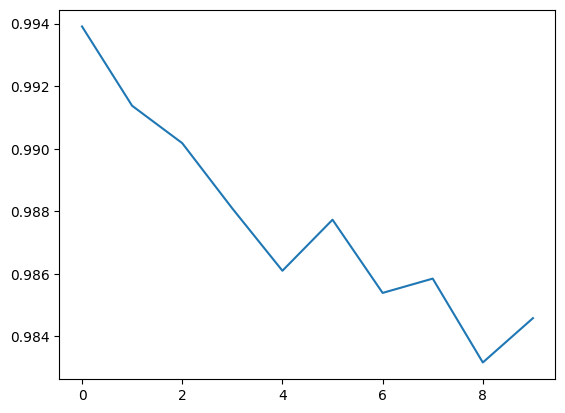

In [ ]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.show()

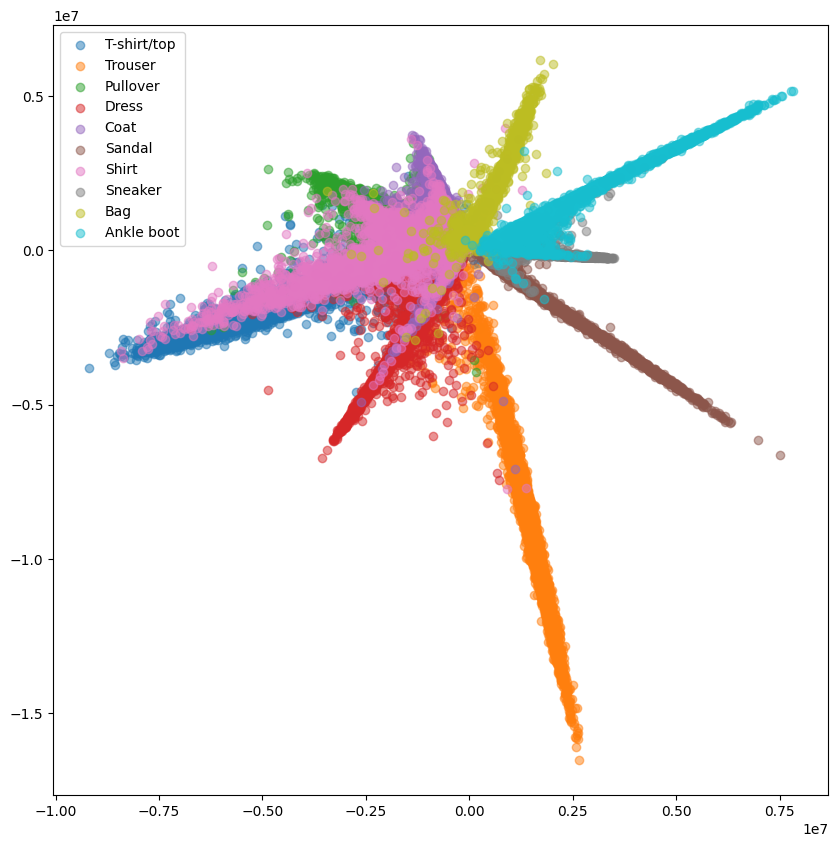

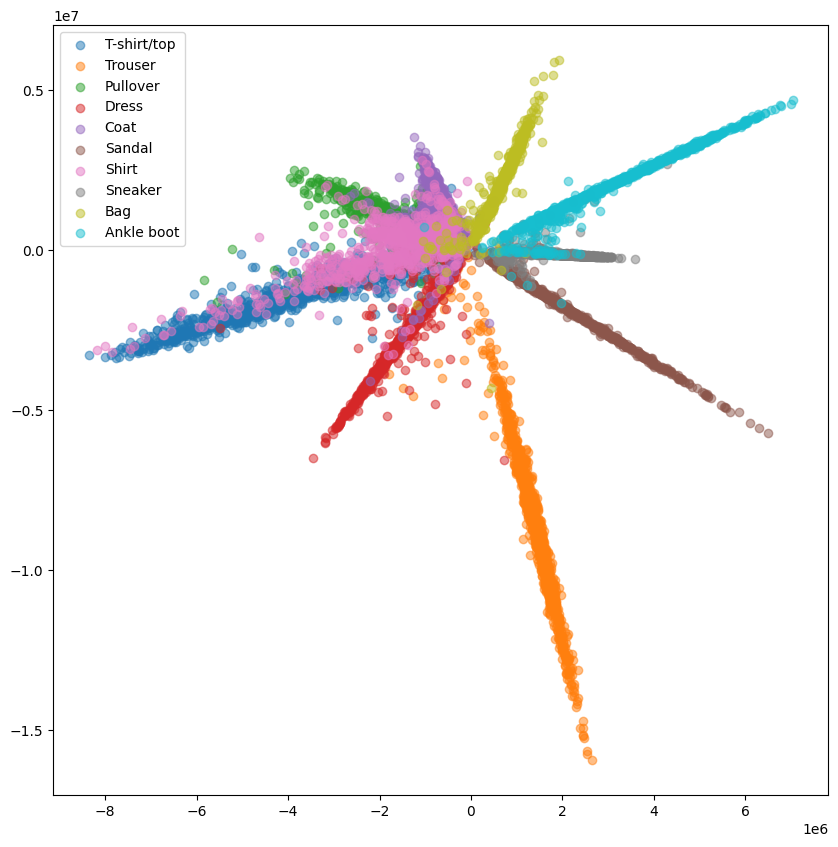

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [ ]:
#Your Code Here


Epoch 1 Iteration 0: Loss = 0.6675583720207214, Number of mined triplets = 117183
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:04<00:00, 70.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 2 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 109.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 109.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 4 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 108.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 5 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:03<00:00, 92.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 6 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 110.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 7 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 109.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 8 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:03<00:00, 103.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 9 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:04<00:00, 77.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 10 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 109.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26058333333333333
Epoch 1 Iteration 0: Loss = 1.000587821006775, Number of mined triplets = 416699
Epoch 1 Iteration 20: Loss = 1.000009536743164, Number of mined triplets = 509860
Epoch 1 Iteration 40: Loss = 1.000002384185791, Number of mined triplets = 530179
Epoch 1 Iteration 60: Loss = 1.0000007152557373, Number of mined triplets = 450697
Epoch 1 Iteration 80: Loss = 1.0000008344650269, Number of mined triplets = 496305
Epoch 1 Iteration 100: Loss = 1.000001072883606, Number of mined triplets = 447102
Epoch 1 Iteration 120: Loss = 1.0000008344650269, Number of mined triplets = 454529
Epoch 1 Iteration 140: Loss = 1.0000005960464478, Number of mined triplets = 406005
Epoch 1 Iteration 160: Loss = 1.0000007152557373, Number of mined triplets = 411987
Epoch 1 Iteration 180: Loss = 1.0000004768371582, Number of mined triplets = 445376
Epoch 1 Iteration 200: Loss = 1.0000003576278687, Number of mined triplets = 442172
Epoch 1 Itera

100%|██████████| 313/313 [00:03<00:00, 100.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2617666666666667
Epoch 2 Iteration 0: Loss = 1.0000003576278687, Number of mined triplets = 386963
Epoch 2 Iteration 20: Loss = 1.0000004768371582, Number of mined triplets = 457538
Epoch 2 Iteration 40: Loss = 1.000000238418579, Number of mined triplets = 418265
Epoch 2 Iteration 60: Loss = 1.0000004768371582, Number of mined triplets = 492545
Epoch 2 Iteration 80: Loss = 1.0000004768371582, Number of mined triplets = 397149
Epoch 2 Iteration 100: Loss = 1.000000238418579, Number of mined triplets = 420467
Epoch 2 Iteration 120: Loss = 1.000000238418579, Number of mined triplets = 444190
Epoch 2 Iteration 140: Loss = 1.000000238418579, Number of mined triplets = 410594
Epoch 2 Iteration 160: Loss = 1.000000238418579, Number of mined triplets = 497617
Epoch 2 Iteration 180: Loss = 1.000000238418579, Number of mined triplets = 436169
Epoch 2 Iteration 200: Loss = 1.000000238418579, Number of mined triplets = 488214
Epoch 2 Iteration

100%|██████████| 313/313 [00:02<00:00, 111.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24665
Epoch 3 Iteration 0: Loss = 1.000000238418579, Number of mined triplets = 442314
Epoch 3 Iteration 20: Loss = 1.000000238418579, Number of mined triplets = 448066
Epoch 3 Iteration 40: Loss = 1.000000238418579, Number of mined triplets = 446043
Epoch 3 Iteration 60: Loss = 1.0000003576278687, Number of mined triplets = 447318
Epoch 3 Iteration 80: Loss = 1.000000238418579, Number of mined triplets = 403991
Epoch 3 Iteration 100: Loss = 1.000000238418579, Number of mined triplets = 417908
Epoch 3 Iteration 120: Loss = 1.0, Number of mined triplets = 414977
Epoch 3 Iteration 140: Loss = 1.0000001192092896, Number of mined triplets = 396210
Epoch 3 Iteration 160: Loss = 1.0, Number of mined triplets = 468490
Epoch 3 Iteration 180: Loss = 1.0000001192092896, Number of mined triplets = 376179
Epoch 3 Iteration 200: Loss = 1.0000001192092896, Number of mined triplets = 424578
Epoch 3 Iteration 220: Loss = 1.0000001192092896, Number

100%|██████████| 313/313 [00:02<00:00, 107.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24736666666666668
Epoch 4 Iteration 0: Loss = 1.0000001192092896, Number of mined triplets = 502490
Epoch 4 Iteration 20: Loss = 0.9999999403953552, Number of mined triplets = 447797
Epoch 4 Iteration 40: Loss = 1.0, Number of mined triplets = 417435
Epoch 4 Iteration 60: Loss = 1.0, Number of mined triplets = 439203
Epoch 4 Iteration 80: Loss = 1.0, Number of mined triplets = 490294
Epoch 4 Iteration 100: Loss = 1.0, Number of mined triplets = 400292
Epoch 4 Iteration 120: Loss = 1.0, Number of mined triplets = 495422
Epoch 4 Iteration 140: Loss = 1.0, Number of mined triplets = 490623
Epoch 4 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 407056
Epoch 4 Iteration 180: Loss = 1.0, Number of mined triplets = 400582
Epoch 4 Iteration 200: Loss = 1.0, Number of mined triplets = 503715
Epoch 4 Iteration 220: Loss = 1.0, Number of mined triplets = 461657


100%|██████████| 313/313 [00:04<00:00, 71.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27831666666666666
Epoch 5 Iteration 0: Loss = 1.0, Number of mined triplets = 433684
Epoch 5 Iteration 20: Loss = 1.0, Number of mined triplets = 453056
Epoch 5 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 427233
Epoch 5 Iteration 60: Loss = 1.0, Number of mined triplets = 407734
Epoch 5 Iteration 80: Loss = 1.0, Number of mined triplets = 476981
Epoch 5 Iteration 100: Loss = 1.0, Number of mined triplets = 467946
Epoch 5 Iteration 120: Loss = 1.0, Number of mined triplets = 429334
Epoch 5 Iteration 140: Loss = 1.0, Number of mined triplets = 451233
Epoch 5 Iteration 160: Loss = 1.0, Number of mined triplets = 415682
Epoch 5 Iteration 180: Loss = 1.0, Number of mined triplets = 391347
Epoch 5 Iteration 200: Loss = 1.0, Number of mined triplets = 400823
Epoch 5 Iteration 220: Loss = 1.0, Number of mined triplets = 439650


100%|██████████| 313/313 [00:03<00:00, 97.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27058333333333334
Epoch 6 Iteration 0: Loss = 1.0, Number of mined triplets = 462443
Epoch 6 Iteration 20: Loss = 1.0, Number of mined triplets = 413094
Epoch 6 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 451828
Epoch 6 Iteration 60: Loss = 1.0, Number of mined triplets = 415352
Epoch 6 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 448897
Epoch 6 Iteration 100: Loss = 1.0, Number of mined triplets = 452157
Epoch 6 Iteration 120: Loss = 1.0, Number of mined triplets = 416698
Epoch 6 Iteration 140: Loss = 1.0, Number of mined triplets = 430872
Epoch 6 Iteration 160: Loss = 1.0, Number of mined triplets = 436165
Epoch 6 Iteration 180: Loss = 0.9999999403953552, Number of mined triplets = 401490
Epoch 6 Iteration 200: Loss = 1.0, Number of mined triplets = 411514
Epoch 6 Iteration 220: Loss = 1.0, Number of mined triplets = 382108


100%|██████████| 313/313 [00:02<00:00, 109.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2962166666666667
Epoch 7 Iteration 0: Loss = 0.9999999403953552, Number of mined triplets = 409393
Epoch 7 Iteration 20: Loss = 1.0, Number of mined triplets = 452286
Epoch 7 Iteration 40: Loss = 1.0, Number of mined triplets = 423657
Epoch 7 Iteration 60: Loss = 1.0, Number of mined triplets = 427237
Epoch 7 Iteration 80: Loss = 1.0, Number of mined triplets = 435839
Epoch 7 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 435772
Epoch 7 Iteration 120: Loss = 1.0, Number of mined triplets = 447404
Epoch 7 Iteration 140: Loss = 1.0, Number of mined triplets = 369406
Epoch 7 Iteration 160: Loss = 1.0, Number of mined triplets = 406236
Epoch 7 Iteration 180: Loss = 1.0, Number of mined triplets = 375972
Epoch 7 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 465490
Epoch 7 Iteration 220: Loss = 1.0, Number of mined triplets = 425585


100%|██████████| 313/313 [00:02<00:00, 109.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3249166666666667
Epoch 8 Iteration 0: Loss = 1.0, Number of mined triplets = 410766
Epoch 8 Iteration 20: Loss = 1.0, Number of mined triplets = 386613
Epoch 8 Iteration 40: Loss = 1.0, Number of mined triplets = 457319
Epoch 8 Iteration 60: Loss = 0.9999999403953552, Number of mined triplets = 408555
Epoch 8 Iteration 80: Loss = 1.0, Number of mined triplets = 384083
Epoch 8 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 387666
Epoch 8 Iteration 120: Loss = 1.0, Number of mined triplets = 455620
Epoch 8 Iteration 140: Loss = 1.0, Number of mined triplets = 367180
Epoch 8 Iteration 160: Loss = 1.0, Number of mined triplets = 404695
Epoch 8 Iteration 180: Loss = 1.0, Number of mined triplets = 490681
Epoch 8 Iteration 200: Loss = 1.0, Number of mined triplets = 374408
Epoch 8 Iteration 220: Loss = 1.0, Number of mined triplets = 409090


100%|██████████| 313/313 [00:02<00:00, 105.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3337833333333334
Epoch 9 Iteration 0: Loss = 0.9999999403953552, Number of mined triplets = 395720
Epoch 9 Iteration 20: Loss = 1.0, Number of mined triplets = 463097
Epoch 9 Iteration 40: Loss = 1.0, Number of mined triplets = 391879
Epoch 9 Iteration 60: Loss = 1.0, Number of mined triplets = 408430
Epoch 9 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 341325
Epoch 9 Iteration 100: Loss = 1.0, Number of mined triplets = 327787
Epoch 9 Iteration 120: Loss = 1.0, Number of mined triplets = 427869
Epoch 9 Iteration 140: Loss = 1.0, Number of mined triplets = 403192
Epoch 9 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 390444
Epoch 9 Iteration 180: Loss = 1.0, Number of mined triplets = 432299
Epoch 9 Iteration 200: Loss = 1.0, Number of mined triplets = 404417
Epoch 9 Iteration 220: Loss = 1.0, Number of mined triplets = 361272


100%|██████████| 313/313 [00:03<00:00, 80.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3138666666666667
Epoch 10 Iteration 0: Loss = 1.0, Number of mined triplets = 402526
Epoch 10 Iteration 20: Loss = 1.0, Number of mined triplets = 465412
Epoch 10 Iteration 40: Loss = 1.0, Number of mined triplets = 384984
Epoch 10 Iteration 60: Loss = 1.0, Number of mined triplets = 358863
Epoch 10 Iteration 80: Loss = 1.0, Number of mined triplets = 419449
Epoch 10 Iteration 100: Loss = 1.0, Number of mined triplets = 409601
Epoch 10 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 385846
Epoch 10 Iteration 140: Loss = 1.0, Number of mined triplets = 418483
Epoch 10 Iteration 160: Loss = 1.0, Number of mined triplets = 437016
Epoch 10 Iteration 180: Loss = 1.0, Number of mined triplets = 379369
Epoch 10 Iteration 200: Loss = 1.0, Number of mined triplets = 423985
Epoch 10 Iteration 220: Loss = 1.0, Number of mined triplets = 416358


100%|██████████| 313/313 [00:02<00:00, 110.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.35946666666666666
Epoch 1 Iteration 0: Loss = 0.9999993443489075, Number of mined triplets = 1151001
Epoch 1 Iteration 20: Loss = 0.9759782552719116, Number of mined triplets = 418727
Epoch 1 Iteration 40: Loss = 0.9179584383964539, Number of mined triplets = 183081
Epoch 1 Iteration 60: Loss = 0.9156200885772705, Number of mined triplets = 157519
Epoch 1 Iteration 80: Loss = 0.9105156660079956, Number of mined triplets = 155071
Epoch 1 Iteration 100: Loss = 0.9105560183525085, Number of mined triplets = 144300
Epoch 1 Iteration 120: Loss = 0.9150381684303284, Number of mined triplets = 153054
Epoch 1 Iteration 140: Loss = 0.9145415425300598, Number of mined triplets = 145533
Epoch 1 Iteration 160: Loss = 0.9273884892463684, Number of mined triplets = 127064
Epoch 1 Iteration 180: Loss = 0.9116775393486023, Number of mined triplets = 131948
Epoch 1 Iteration 200: Loss = 0.9139215350151062, Number of mined triplets = 125366
Epoch 1 

100%|██████████| 313/313 [00:02<00:00, 109.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6406166666666667
Epoch 2 Iteration 0: Loss = 0.9090781807899475, Number of mined triplets = 160774
Epoch 2 Iteration 20: Loss = 0.9153540730476379, Number of mined triplets = 141767
Epoch 2 Iteration 40: Loss = 0.8937555551528931, Number of mined triplets = 143211
Epoch 2 Iteration 60: Loss = 0.8967946767807007, Number of mined triplets = 126600
Epoch 2 Iteration 80: Loss = 0.8923230171203613, Number of mined triplets = 141256
Epoch 2 Iteration 100: Loss = 0.9026461839675903, Number of mined triplets = 152855
Epoch 2 Iteration 120: Loss = 0.9004454016685486, Number of mined triplets = 180776
Epoch 2 Iteration 140: Loss = 0.893848717212677, Number of mined triplets = 132897
Epoch 2 Iteration 160: Loss = 0.8894221186637878, Number of mined triplets = 132029
Epoch 2 Iteration 180: Loss = 0.9003896713256836, Number of mined triplets = 141254
Epoch 2 Iteration 200: Loss = 0.9007889628410339, Number of mined triplets = 153571
Epoch 2 Ite

100%|██████████| 313/313 [00:02<00:00, 107.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7204833333333334
Epoch 3 Iteration 0: Loss = 0.8906141519546509, Number of mined triplets = 127413
Epoch 3 Iteration 20: Loss = 0.8886152505874634, Number of mined triplets = 138038
Epoch 3 Iteration 40: Loss = 0.8728079199790955, Number of mined triplets = 146260
Epoch 3 Iteration 60: Loss = 0.8884549736976624, Number of mined triplets = 156587
Epoch 3 Iteration 80: Loss = 0.897407591342926, Number of mined triplets = 130388
Epoch 3 Iteration 100: Loss = 0.8930570483207703, Number of mined triplets = 127396
Epoch 3 Iteration 120: Loss = 0.88239985704422, Number of mined triplets = 131352
Epoch 3 Iteration 140: Loss = 0.8734982013702393, Number of mined triplets = 138806
Epoch 3 Iteration 160: Loss = 0.8982575535774231, Number of mined triplets = 130380
Epoch 3 Iteration 180: Loss = 0.8970230221748352, Number of mined triplets = 147253
Epoch 3 Iteration 200: Loss = 0.8859158158302307, Number of mined triplets = 131395
Epoch 3 Itera

100%|██████████| 313/313 [00:03<00:00, 102.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7421833333333334
Epoch 4 Iteration 0: Loss = 0.8893803358078003, Number of mined triplets = 144495
Epoch 4 Iteration 20: Loss = 0.8857382535934448, Number of mined triplets = 175158
Epoch 4 Iteration 40: Loss = 0.8854541182518005, Number of mined triplets = 141267
Epoch 4 Iteration 60: Loss = 0.8948966860771179, Number of mined triplets = 116373
Epoch 4 Iteration 80: Loss = 0.8903790712356567, Number of mined triplets = 105123
Epoch 4 Iteration 100: Loss = 0.8830097913742065, Number of mined triplets = 106687
Epoch 4 Iteration 120: Loss = 0.8775653839111328, Number of mined triplets = 115511
Epoch 4 Iteration 140: Loss = 0.8954774737358093, Number of mined triplets = 99345
Epoch 4 Iteration 160: Loss = 0.8964855074882507, Number of mined triplets = 139198
Epoch 4 Iteration 180: Loss = 0.8796872496604919, Number of mined triplets = 137334
Epoch 4 Iteration 200: Loss = 0.8964446187019348, Number of mined triplets = 135477
Epoch 4 Ite

100%|██████████| 313/313 [00:04<00:00, 71.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7561166666666667
Epoch 5 Iteration 0: Loss = 0.8733752965927124, Number of mined triplets = 133545
Epoch 5 Iteration 20: Loss = 0.8814982771873474, Number of mined triplets = 143502
Epoch 5 Iteration 40: Loss = 0.8854742646217346, Number of mined triplets = 118137
Epoch 5 Iteration 60: Loss = 0.8914634585380554, Number of mined triplets = 122492
Epoch 5 Iteration 80: Loss = 0.8867185115814209, Number of mined triplets = 134579
Epoch 5 Iteration 100: Loss = 0.8805587887763977, Number of mined triplets = 112404
Epoch 5 Iteration 120: Loss = 0.9054033160209656, Number of mined triplets = 137269
Epoch 5 Iteration 140: Loss = 0.8903842568397522, Number of mined triplets = 133339
Epoch 5 Iteration 160: Loss = 0.8787682056427002, Number of mined triplets = 104717
Epoch 5 Iteration 180: Loss = 0.8863816261291504, Number of mined triplets = 117717
Epoch 5 Iteration 200: Loss = 0.8994522094726562, Number of mined triplets = 120273
Epoch 5 It

100%|██████████| 313/313 [00:02<00:00, 106.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7755666666666667
Epoch 6 Iteration 0: Loss = 0.8805926442146301, Number of mined triplets = 136978
Epoch 6 Iteration 20: Loss = 0.8873832821846008, Number of mined triplets = 126996
Epoch 6 Iteration 40: Loss = 0.8673954606056213, Number of mined triplets = 155976
Epoch 6 Iteration 60: Loss = 0.8760807514190674, Number of mined triplets = 153563
Epoch 6 Iteration 80: Loss = 0.8838728666305542, Number of mined triplets = 120663
Epoch 6 Iteration 100: Loss = 0.895611047744751, Number of mined triplets = 105771
Epoch 6 Iteration 120: Loss = 0.8830659985542297, Number of mined triplets = 120205
Epoch 6 Iteration 140: Loss = 0.8665684461593628, Number of mined triplets = 145384
Epoch 6 Iteration 160: Loss = 0.8800336122512817, Number of mined triplets = 141607
Epoch 6 Iteration 180: Loss = 0.8673427700996399, Number of mined triplets = 145528
Epoch 6 Iteration 200: Loss = 0.8831444382667542, Number of mined triplets = 116681
Epoch 6 Ite

100%|██████████| 313/313 [00:02<00:00, 107.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.784
Epoch 7 Iteration 0: Loss = 0.8768582940101624, Number of mined triplets = 102127
Epoch 7 Iteration 20: Loss = 0.8855828642845154, Number of mined triplets = 123311
Epoch 7 Iteration 40: Loss = 0.8765097856521606, Number of mined triplets = 93613
Epoch 7 Iteration 60: Loss = 0.8895630240440369, Number of mined triplets = 129547
Epoch 7 Iteration 80: Loss = 0.8856734037399292, Number of mined triplets = 114989
Epoch 7 Iteration 100: Loss = 0.8936974406242371, Number of mined triplets = 105414
Epoch 7 Iteration 120: Loss = 0.8732466697692871, Number of mined triplets = 129003
Epoch 7 Iteration 140: Loss = 0.8858565092086792, Number of mined triplets = 101485
Epoch 7 Iteration 160: Loss = 0.87214595079422, Number of mined triplets = 130131
Epoch 7 Iteration 180: Loss = 0.8791937828063965, Number of mined triplets = 140643
Epoch 7 Iteration 200: Loss = 0.8935810923576355, Number of mined triplets = 105436
Epoch 7 Iteration 220: Los

100%|██████████| 313/313 [00:03<00:00, 104.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8011
Epoch 8 Iteration 0: Loss = 0.8597918748855591, Number of mined triplets = 140339
Epoch 8 Iteration 20: Loss = 0.8696525692939758, Number of mined triplets = 115800
Epoch 8 Iteration 40: Loss = 0.8883794546127319, Number of mined triplets = 138891
Epoch 8 Iteration 60: Loss = 0.8818996548652649, Number of mined triplets = 115852
Epoch 8 Iteration 80: Loss = 0.8938634395599365, Number of mined triplets = 110879
Epoch 8 Iteration 100: Loss = 0.8684397339820862, Number of mined triplets = 126591
Epoch 8 Iteration 120: Loss = 0.8681595325469971, Number of mined triplets = 146147
Epoch 8 Iteration 140: Loss = 0.8754837512969971, Number of mined triplets = 114709
Epoch 8 Iteration 160: Loss = 0.8837623000144958, Number of mined triplets = 151173
Epoch 8 Iteration 180: Loss = 0.8776170611381531, Number of mined triplets = 91659
Epoch 8 Iteration 200: Loss = 0.8720746636390686, Number of mined triplets = 122748
Epoch 8 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 106.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8003333333333333
Epoch 9 Iteration 0: Loss = 0.8870901465415955, Number of mined triplets = 115633
Epoch 9 Iteration 20: Loss = 0.880204975605011, Number of mined triplets = 120181
Epoch 9 Iteration 40: Loss = 0.882908821105957, Number of mined triplets = 120836
Epoch 9 Iteration 60: Loss = 0.8693559169769287, Number of mined triplets = 125961
Epoch 9 Iteration 80: Loss = 0.8911724090576172, Number of mined triplets = 117142
Epoch 9 Iteration 100: Loss = 0.8933876752853394, Number of mined triplets = 98959
Epoch 9 Iteration 120: Loss = 0.8874344229698181, Number of mined triplets = 112538
Epoch 9 Iteration 140: Loss = 0.8834420442581177, Number of mined triplets = 110333
Epoch 9 Iteration 160: Loss = 0.8850666880607605, Number of mined triplets = 120208
Epoch 9 Iteration 180: Loss = 0.8737493753433228, Number of mined triplets = 146188
Epoch 9 Iteration 200: Loss = 0.8772160410881042, Number of mined triplets = 105945
Epoch 9 Itera

100%|██████████| 313/313 [00:04<00:00, 66.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8184833333333333
Epoch 10 Iteration 0: Loss = 0.8878335952758789, Number of mined triplets = 119203
Epoch 10 Iteration 20: Loss = 0.8640961647033691, Number of mined triplets = 137845
Epoch 10 Iteration 40: Loss = 0.8733839988708496, Number of mined triplets = 119815
Epoch 10 Iteration 60: Loss = 0.8717375993728638, Number of mined triplets = 101814
Epoch 10 Iteration 80: Loss = 0.8768631219863892, Number of mined triplets = 112713
Epoch 10 Iteration 100: Loss = 0.8920878767967224, Number of mined triplets = 109186
Epoch 10 Iteration 120: Loss = 0.8807663321495056, Number of mined triplets = 135714
Epoch 10 Iteration 140: Loss = 0.8683261871337891, Number of mined triplets = 120864
Epoch 10 Iteration 160: Loss = 0.8792944550514221, Number of mined triplets = 112227
Epoch 10 Iteration 180: Loss = 0.8795174360275269, Number of mined triplets = 102778
Epoch 10 Iteration 200: Loss = 0.8844822645187378, Number of mined triplets = 117590

100%|██████████| 313/313 [00:02<00:00, 105.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8203666666666667


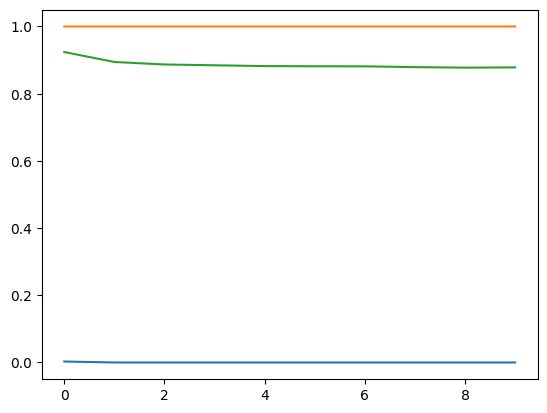

In [ ]:
# SOLUTION

model = EmbeddingNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for triplet in ["easy", "hard", "semihard"]:
    mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets=triplet)
    loss_evolution = []
    for epoch in range(1, num_epochs + 1):
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        loss_evolution.append(loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)

    plt.plot(loss_evolution, label=triplet)
plt.legend()
plt.show()

<br>
<span style="color:blue">

**Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [ ]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE.

We will use the T-SNE library from sklearn, you can see the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for info on how to use it.

Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few hundreds**

</span>

In [ ]:
# Your Code Here


In [ ]:
# SOLUTION

class EmbeddingNet_128(nn.Module):
    def __init__(self):
        super(EmbeddingNet_128, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet_128().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
num_epochs = 10

for epoch in range(num_epochs):
    train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 0 Iteration 0: Loss = 0.9684343338012695, Number of mined triplets = 1195223
Epoch 0 Iteration 20: Loss = 0.9934200048446655, Number of mined triplets = 352401
Epoch 0 Iteration 40: Loss = 1.031162977218628, Number of mined triplets = 270012
Epoch 0 Iteration 60: Loss = 0.9833781719207764, Number of mined triplets = 172595
Epoch 0 Iteration 80: Loss = 1.0084477663040161, Number of mined triplets = 190554
Epoch 0 Iteration 100: Loss = 0.9970921874046326, Number of mined triplets = 202211
Epoch 0 Iteration 120: Loss = 1.0118824243545532, Number of mined triplets = 180560
Epoch 0 Iteration 140: Loss = 0.9873712658882141, Number of mined triplets = 201028
Epoch 0 Iteration 160: Loss = 1.0075652599334717, Number of mined triplets = 158500
Epoch 0 Iteration 180: Loss = 0.9645933508872986, Number of mined triplets = 180635
Epoch 0 Iteration 200: Loss = 0.9951213002204895, Number of mined triplets = 182278
Epoch 0 Iteration 220: Loss = 1.0172327756881714, Number of mined triplets = 16624

100%|██████████| 313/313 [00:02<00:00, 108.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8600166666666668
Epoch 1 Iteration 0: Loss = 0.9835886359214783, Number of mined triplets = 194130
Epoch 1 Iteration 20: Loss = 1.0123698711395264, Number of mined triplets = 144836
Epoch 1 Iteration 40: Loss = 0.9879105687141418, Number of mined triplets = 135952
Epoch 1 Iteration 60: Loss = 1.0096434354782104, Number of mined triplets = 86840
Epoch 1 Iteration 80: Loss = 1.017492413520813, Number of mined triplets = 163781
Epoch 1 Iteration 100: Loss = 1.0001636743545532, Number of mined triplets = 157071
Epoch 1 Iteration 120: Loss = 1.0195772647857666, Number of mined triplets = 124923
Epoch 1 Iteration 140: Loss = 0.9957018494606018, Number of mined triplets = 146928
Epoch 1 Iteration 160: Loss = 0.984279453754425, Number of mined triplets = 150445
Epoch 1 Iteration 180: Loss = 1.0154377222061157, Number of mined triplets = 177562
Epoch 1 Iteration 200: Loss = 0.9929664134979248, Number of mined triplets = 125151
Epoch 1 Itera

100%|██████████| 313/313 [00:02<00:00, 113.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.88275
Epoch 2 Iteration 0: Loss = 0.9972461462020874, Number of mined triplets = 77898
Epoch 2 Iteration 20: Loss = 0.9978275895118713, Number of mined triplets = 103264
Epoch 2 Iteration 40: Loss = 1.0211875438690186, Number of mined triplets = 108421
Epoch 2 Iteration 60: Loss = 0.9857951998710632, Number of mined triplets = 126493
Epoch 2 Iteration 80: Loss = 0.982488214969635, Number of mined triplets = 62914
Epoch 2 Iteration 100: Loss = 0.9853494167327881, Number of mined triplets = 123201
Epoch 2 Iteration 120: Loss = 1.0054986476898193, Number of mined triplets = 93384
Epoch 2 Iteration 140: Loss = 0.9953906536102295, Number of mined triplets = 74446
Epoch 2 Iteration 160: Loss = 0.9789069890975952, Number of mined triplets = 94279
Epoch 2 Iteration 180: Loss = 1.0058327913284302, Number of mined triplets = 93547
Epoch 2 Iteration 200: Loss = 1.022722840309143, Number of mined triplets = 139615
Epoch 2 Iteration 220: Loss =

100%|██████████| 313/313 [00:02<00:00, 113.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.89365
Epoch 3 Iteration 0: Loss = 0.9940372705459595, Number of mined triplets = 102377
Epoch 3 Iteration 20: Loss = 0.9898305535316467, Number of mined triplets = 78756
Epoch 3 Iteration 40: Loss = 0.9802486896514893, Number of mined triplets = 78788
Epoch 3 Iteration 60: Loss = 1.0245106220245361, Number of mined triplets = 81044
Epoch 3 Iteration 80: Loss = 0.993710458278656, Number of mined triplets = 78536
Epoch 3 Iteration 100: Loss = 0.9992989301681519, Number of mined triplets = 92959
Epoch 3 Iteration 120: Loss = 0.982517421245575, Number of mined triplets = 100493
Epoch 3 Iteration 140: Loss = 1.031752347946167, Number of mined triplets = 111587
Epoch 3 Iteration 160: Loss = 0.9968529939651489, Number of mined triplets = 103655
Epoch 3 Iteration 180: Loss = 0.9831145405769348, Number of mined triplets = 108279
Epoch 3 Iteration 200: Loss = 0.987099289894104, Number of mined triplets = 84973
Epoch 3 Iteration 220: Loss = 1

100%|██████████| 313/313 [00:04<00:00, 70.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9025166666666667
Epoch 4 Iteration 0: Loss = 0.9822974801063538, Number of mined triplets = 111949
Epoch 4 Iteration 20: Loss = 0.9643693566322327, Number of mined triplets = 96648
Epoch 4 Iteration 40: Loss = 0.9847524166107178, Number of mined triplets = 67484
Epoch 4 Iteration 60: Loss = 0.994148850440979, Number of mined triplets = 82288
Epoch 4 Iteration 80: Loss = 0.98417729139328, Number of mined triplets = 85687
Epoch 4 Iteration 100: Loss = 0.9827401638031006, Number of mined triplets = 74706
Epoch 4 Iteration 120: Loss = 1.0240230560302734, Number of mined triplets = 91168
Epoch 4 Iteration 140: Loss = 0.9715773463249207, Number of mined triplets = 91216
Epoch 4 Iteration 160: Loss = 0.9997109174728394, Number of mined triplets = 91935
Epoch 4 Iteration 180: Loss = 0.9839346408843994, Number of mined triplets = 93136
Epoch 4 Iteration 200: Loss = 0.9958513975143433, Number of mined triplets = 117698
Epoch 4 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 113.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9097500000000001
Epoch 5 Iteration 0: Loss = 0.9989066123962402, Number of mined triplets = 98485
Epoch 5 Iteration 20: Loss = 0.9742452502250671, Number of mined triplets = 88441
Epoch 5 Iteration 40: Loss = 1.0061092376708984, Number of mined triplets = 68208
Epoch 5 Iteration 60: Loss = 0.9914684295654297, Number of mined triplets = 80356
Epoch 5 Iteration 80: Loss = 0.9993227124214172, Number of mined triplets = 112416
Epoch 5 Iteration 100: Loss = 0.9975892305374146, Number of mined triplets = 119623
Epoch 5 Iteration 120: Loss = 1.0012550354003906, Number of mined triplets = 94585
Epoch 5 Iteration 140: Loss = 0.9833024144172668, Number of mined triplets = 71337
Epoch 5 Iteration 160: Loss = 0.9863254427909851, Number of mined triplets = 121549
Epoch 5 Iteration 180: Loss = 1.012804388999939, Number of mined triplets = 96882
Epoch 5 Iteration 200: Loss = 0.9953792095184326, Number of mined triplets = 85024
Epoch 5 Iteration 2

100%|██████████| 313/313 [00:02<00:00, 113.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9120333333333334
Epoch 6 Iteration 0: Loss = 1.0103697776794434, Number of mined triplets = 84109
Epoch 6 Iteration 20: Loss = 1.0156339406967163, Number of mined triplets = 64836
Epoch 6 Iteration 40: Loss = 0.9929449558258057, Number of mined triplets = 56689
Epoch 6 Iteration 60: Loss = 0.9945271611213684, Number of mined triplets = 57333
Epoch 6 Iteration 80: Loss = 0.9698317050933838, Number of mined triplets = 73092
Epoch 6 Iteration 100: Loss = 1.0050098896026611, Number of mined triplets = 92831
Epoch 6 Iteration 120: Loss = 1.0124212503433228, Number of mined triplets = 89424
Epoch 6 Iteration 140: Loss = 0.9461273550987244, Number of mined triplets = 72586
Epoch 6 Iteration 160: Loss = 1.0175096988677979, Number of mined triplets = 99734
Epoch 6 Iteration 180: Loss = 0.9907413125038147, Number of mined triplets = 77942
Epoch 6 Iteration 200: Loss = 0.9479330778121948, Number of mined triplets = 52714
Epoch 6 Iteration 220

100%|██████████| 313/313 [00:03<00:00, 80.39it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.9153833333333333
Epoch 7 Iteration 0: Loss = 0.9791801571846008, Number of mined triplets = 75491
Epoch 7 Iteration 20: Loss = 0.9983125925064087, Number of mined triplets = 59414
Epoch 7 Iteration 40: Loss = 0.9790151715278625, Number of mined triplets = 58438
Epoch 7 Iteration 60: Loss = 0.998009443283081, Number of mined triplets = 54654
Epoch 7 Iteration 80: Loss = 0.9752055406570435, Number of mined triplets = 58210
Epoch 7 Iteration 100: Loss = 0.987494945526123, Number of mined triplets = 63464
Epoch 7 Iteration 120: Loss = 0.9962369799613953, Number of mined triplets = 74909
Epoch 7 Iteration 140: Loss = 1.00040602684021, Number of mined triplets = 103815
Epoch 7 Iteration 160: Loss = 1.0038647651672363, Number of mined triplets = 85295
Epoch 7 Iteration 180: Loss = 0.9751830101013184, Number of mined triplets = 77147
Epoch 7 Iteration 200: Loss = 1.0127195119857788, Number of mined triplets = 64488
Epoch 7 Iteration 220: L

100%|██████████| 313/313 [00:02<00:00, 113.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9210833333333334
Epoch 8 Iteration 0: Loss = 0.990974485874176, Number of mined triplets = 70749
Epoch 8 Iteration 20: Loss = 1.010332465171814, Number of mined triplets = 89046
Epoch 8 Iteration 40: Loss = 1.0035550594329834, Number of mined triplets = 58128
Epoch 8 Iteration 60: Loss = 0.9835098385810852, Number of mined triplets = 89799
Epoch 8 Iteration 80: Loss = 1.0101826190948486, Number of mined triplets = 57156
Epoch 8 Iteration 100: Loss = 1.0078480243682861, Number of mined triplets = 78962
Epoch 8 Iteration 120: Loss = 1.012540578842163, Number of mined triplets = 95677
Epoch 8 Iteration 140: Loss = 0.966239333152771, Number of mined triplets = 55514
Epoch 8 Iteration 160: Loss = 0.9727666974067688, Number of mined triplets = 42520
Epoch 8 Iteration 180: Loss = 0.9646874070167542, Number of mined triplets = 68660
Epoch 8 Iteration 200: Loss = 1.0106419324874878, Number of mined triplets = 82829
Epoch 8 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 113.80it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.92105
Epoch 9 Iteration 0: Loss = 0.9738276600837708, Number of mined triplets = 60309
Epoch 9 Iteration 20: Loss = 0.9768160581588745, Number of mined triplets = 77892
Epoch 9 Iteration 40: Loss = 0.9690025448799133, Number of mined triplets = 48933
Epoch 9 Iteration 60: Loss = 1.0019891262054443, Number of mined triplets = 81326
Epoch 9 Iteration 80: Loss = 0.9679110646247864, Number of mined triplets = 86587
Epoch 9 Iteration 100: Loss = 0.9742431044578552, Number of mined triplets = 67847
Epoch 9 Iteration 120: Loss = 0.9842914342880249, Number of mined triplets = 55917
Epoch 9 Iteration 140: Loss = 0.9918766617774963, Number of mined triplets = 64209
Epoch 9 Iteration 160: Loss = 0.9966810345649719, Number of mined triplets = 75508
Epoch 9 Iteration 180: Loss = 1.021838665008545, Number of mined triplets = 85221
Epoch 9 Iteration 200: Loss = 1.0142285823822021, Number of mined triplets = 79002
Epoch 9 Iteration 220: Loss = 0.9

100%|██████████| 313/313 [00:02<00:00, 111.94it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9227500000000001


  0%|          | 0/313 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▊| 309/313 [00:04<00:00, 70.36it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 313/313 [00:04<00:00, 69.22it/s]


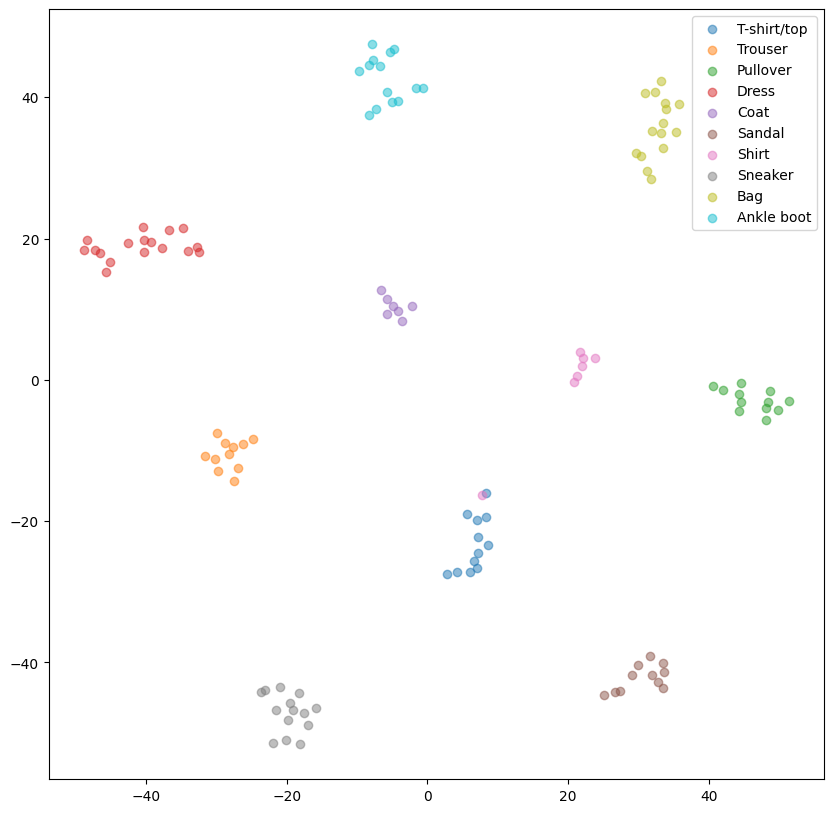

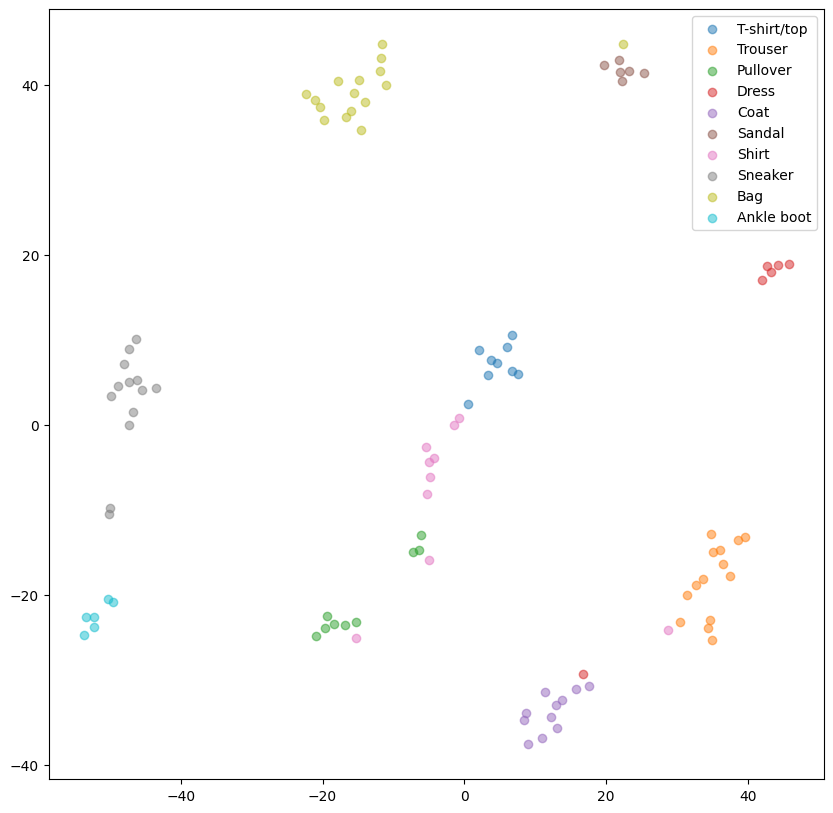

In [ ]:
from sklearn.manifold import TSNE
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)
train_embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(train_embeddings[::500].cpu())
plot_embeddings(train_embeddings, train_labels[::500].cpu()) #Use just the first 500 points of the training set


test_embeddings, test_labels = get_all_embeddings(test_dataset, model)
test_embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(test_embeddings[::100].cpu())
plot_embeddings(test_embeddings, test_labels[::100].cpu()) #Use just the first 100 points of the test set